In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the Chest X-ray Pneumonia dataset from Kaggle
dataset = 'paultimothymooney/chest-xray-pneumonia'
download_path = 'data/raw/'

# Create the directory if it doesn't exist
os.makedirs(download_path, exist_ok=True)

# Download and unzip dataset
api.dataset_download_files(dataset, path=download_path, unzip=True)

# Verify the download
if os.path.exists(os.path.join(download_path, 'chest_xray')):
    print("Dataset successfully downloaded and extracted.")
else:
    print("Download failed.")


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Dataset successfully downloaded and extracted.


In [5]:
# Data Preprocessing - Resizing & Normalization
import cv2
import numpy as np

IMG_SIZE = 224  # Set image size for resizing

# Function to preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize pixel values
    return img

# Preprocess and save images
image_folder = 'data/raw/chest_xray/train'  # Adjust folder for 'train', 'test', or 'val'
processed_folder = 'data/processed/'

os.makedirs(processed_folder, exist_ok=True)

for image_class in os.listdir(image_folder):
    class_folder = os.path.join(image_folder, image_class)
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            img = preprocess_image(os.path.join(class_folder, image_name))
            np.save(os.path.join(processed_folder, f"{image_class}_{image_name}.npy"), img)


In [6]:
# CNN Model Definition
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,906,945 (91.20 MB)

 Trainable params: 23,906,945 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Transfer Learning with ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Build a transfer learning model
def build_transfer_learning_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

transfer_model = build_transfer_learning_model()
transfer_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# Model Training - CNN
# Dummy training dataset (Replace with actual data after preprocessing)
X_train = np.random.rand(100, 224, 224, 1)
y_train = np.random.randint(0, 2, 100)

# Train the CNN model
history = cnn_model.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5156 - loss: 9.0673 - val_accuracy: 0.5000 - val_loss: 3.3292
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4461 - loss: 3.2107 - val_accuracy: 0.5000 - val_loss: 0.9876
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5023 - loss: 1.3821 - val_accuracy: 0.5000 - val_loss: 0.7423
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5156 - loss: 0.7159 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5656 - loss: 0.6808 - val_accuracy: 0.5000 - val_loss: 0.6935


Precision: 0.54
Recall: 0.57
F1 Score: 0.56


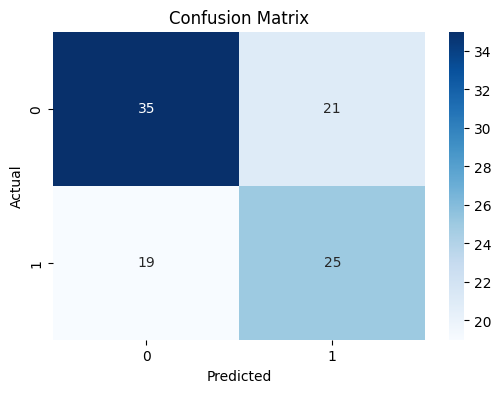

In [9]:
# Model Evaluation - Confusion Matrix & Metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Dummy predictions for demonstration
y_true = np.random.randint(0, 2, 100)
y_pred = np.random.randint(0, 2, 100)

# Evaluation function
def evaluate_model(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(y_true, y_pred)
